### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

In [1]:
import requests
from urllib.parse import urlencode
import os

def download_from_yadisk(short_url: str, filename: str, target_dir: str):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=short_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    target_file = os.path.join(target_dir, filename)
    with open(target_file, 'wb') as f:
        f.write(download_response.content)

In [2]:
#!L
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [1]:
!unzip celeba.zip

In [4]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 2.1.0+cu118
Using GPU


### Prepare Dataset

In [5]:
#!L
class CropCelebA64:

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:
#!L

# Note that for simplicity we reduce the number of channels to 1

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

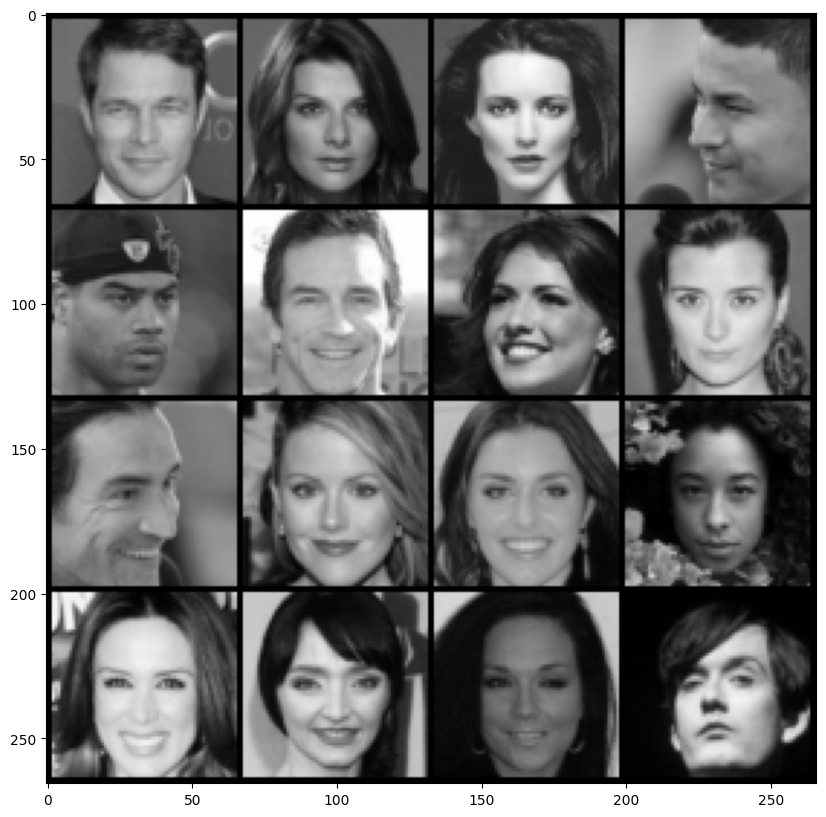

In [7]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help.

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [8]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()

class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape

    def forward(self,input):
        return input.view(self.shape)

In [9]:
#!L
CODE_SIZE = 128 # Size of z noise vector; feel free to change it

generator = nn.Sequential()

generator.add_module('linear1', nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module('act1', nn.ELU())
generator.add_module('reshape1', Reshape([-1, 10, 8, 8]))

generator.add_module('conv1', nn.ConvTranspose2d(10, 128, kernel_size=(5,5), stride=2))
generator.add_module('act2', nn.ELU())

generator.add_module('conv2', nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=2))
generator.add_module('act3', nn.ELU())
generator.add_module('upsample1', nn.Upsample(scale_factor=2, mode='bilinear'))
generator.add_module('act4', nn.ELU())
generator.add_module('conv3', nn.ConvTranspose2d(64, 32, kernel_size=(3,3), padding=(4, 4)))
generator.add_module('act5', nn.ELU())
generator.add_module('conv4', nn.ConvTranspose2d(32, 3, kernel_size=(3,3), padding=(4, 4)))
generator.add_module('act6', nn.ELU())
generator.add_module('out', nn.Conv2d(3, 1, 3))

if use_cuda: generator.cuda()

In [10]:
#!L
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

In [11]:
# Вот так меняется размер при проходе по генератору

h = torch.randn(1, 10, 8, 8)
a = nn.ConvTranspose2d(10, 128, kernel_size=(5,5), stride=2)
h = a(h)
print(h.size())
a = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=2)
h = a(h)
print(h.size())
a = nn.Upsample(scale_factor=2, mode='bilinear')
h = a(h)
print(h.size())
a = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), padding=(4, 4))
h = a(h)
print(h.size())
a = nn.ConvTranspose2d(32, 3, kernel_size=(3,3), padding=(4, 4))
h = a(h)
print(h.size())
a = nn.Conv2d(3, 1, 3)
h = a(h)
print(h.size())

torch.Size([1, 128, 19, 19])
torch.Size([1, 64, 39, 39])
torch.Size([1, 64, 78, 78])
torch.Size([1, 32, 72, 72])
torch.Size([1, 3, 66, 66])
torch.Size([1, 1, 64, 64])


### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [12]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [13]:
#!L
discriminator = nn.Sequential()

discriminator.add_module("conv1", nn.Conv2d(1, 32, 5))
discriminator.add_module('act1', nn.ReLU())
discriminator.add_module("pool1", nn.MaxPool2d(2))
discriminator.add_module("conv2", nn.Conv2d(32, 64, 3))
discriminator.add_module('act2', nn.ReLU())
discriminator.add_module("pool2", nn.MaxPool2d(2))
discriminator.add_module("conv3", nn.Conv2d(64, 128, 3))
discriminator.add_module('act3', nn.ReLU())
discriminator.add_module("pool3", nn.MaxPool2d(2))
discriminator.add_module("conv4", nn.Conv2d(128, 32, 3))
discriminator.add_module('act4', nn.ReLU())

discriminator.add_module("flatten", nn.Flatten())
discriminator.add_module("linear", nn.Linear(128 * 4, 128))
discriminator.add_module('act5', nn.ReLU())
discriminator.add_module("disc_logit", nn.Linear(128, 1))

if use_cuda: discriminator.cuda()

In [14]:
#!L
discriminator(sample_data_batch(4))

tensor([[-0.0866],
        [-0.0839],
        [-0.0857],
        [-0.0844]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [15]:
#!L
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)

    disc_on_generated_data = discriminator(generated_data)

    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)

    loss = -logp_gen_is_real.mean()

    return loss

In [16]:
#!L
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.7377, device='cuda:0', grad_fn=<NegBackward0>)


In [17]:
#!L
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)

    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)

    loss = -(logp_gen_is_fake + logp_real_is_real).mean()
    return loss

In [18]:
#!L
loss = discriminator_loss(sample_data_batch(32),
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.3870, device='cuda:0', grad_fn=<NegBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [19]:
#!L
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))

    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [20]:
#!L
# optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

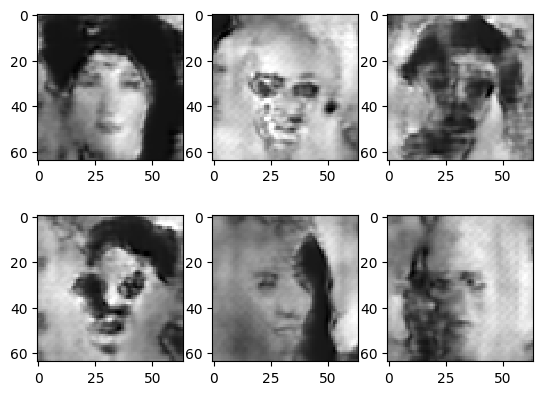

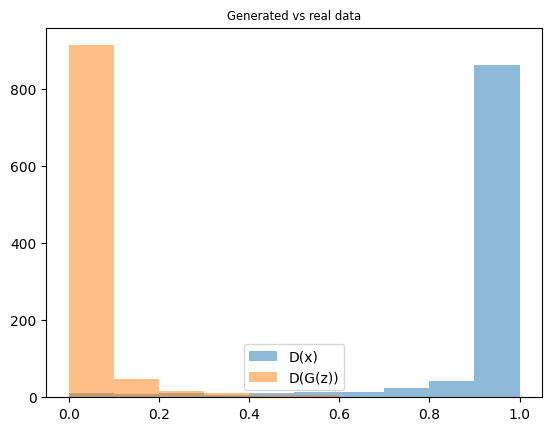

KeyboardInterrupt: ignored

In [73]:
#!L
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in tqdm(range(25)):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            print(epoch)
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)

Тут мне нужно бежать, поэтому стопаю и сохраняю, чтобы потом продолжить. Тут обучилось примерно 7 эпох. Оставлю, чтобы было видно промежуточную историю

In [74]:
from google.colab import files
torch.save(generator.state_dict(), 'generator')
files.download('generator')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
from google.colab import files
torch.save(discriminator.state_dict(), 'discriminator')
files.download('discriminator')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Продолжаем наш репортаж, прямое включение с последнего сохранения

In [21]:
generator.load_state_dict(torch.load('generator'))
generator.eval()

Sequential(
  (linear1): Linear(in_features=128, out_features=640, bias=True)
  (act1): ELU(alpha=1.0)
  (reshape1): Reshape()
  (conv1): ConvTranspose2d(10, 128, kernel_size=(5, 5), stride=(2, 2))
  (act2): ELU(alpha=1.0)
  (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (act3): ELU(alpha=1.0)
  (upsample1): Upsample(scale_factor=2.0, mode='bilinear')
  (act4): ELU(alpha=1.0)
  (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (act5): ELU(alpha=1.0)
  (conv4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (act6): ELU(alpha=1.0)
  (out): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [22]:
discriminator.load_state_dict(torch.load('discriminator'))
discriminator.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1))
  (act4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=128, bias=True)
  (act5): ReLU()
  (disc_logit): Linear(in_features=128, out_features=1, bias=True)
)

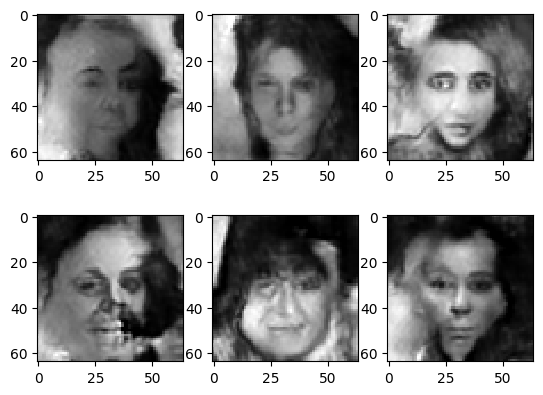

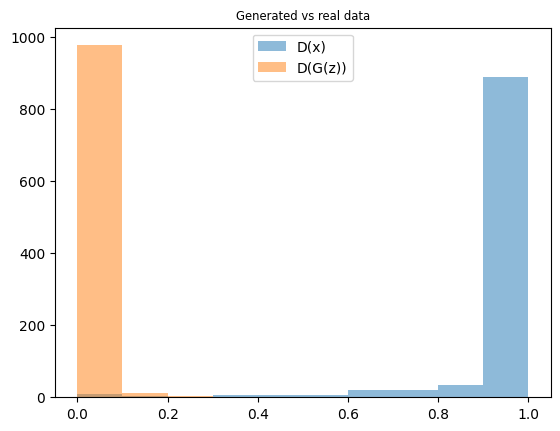

In [23]:
#!L
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in tqdm(range(18)):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            print(epoch)
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)

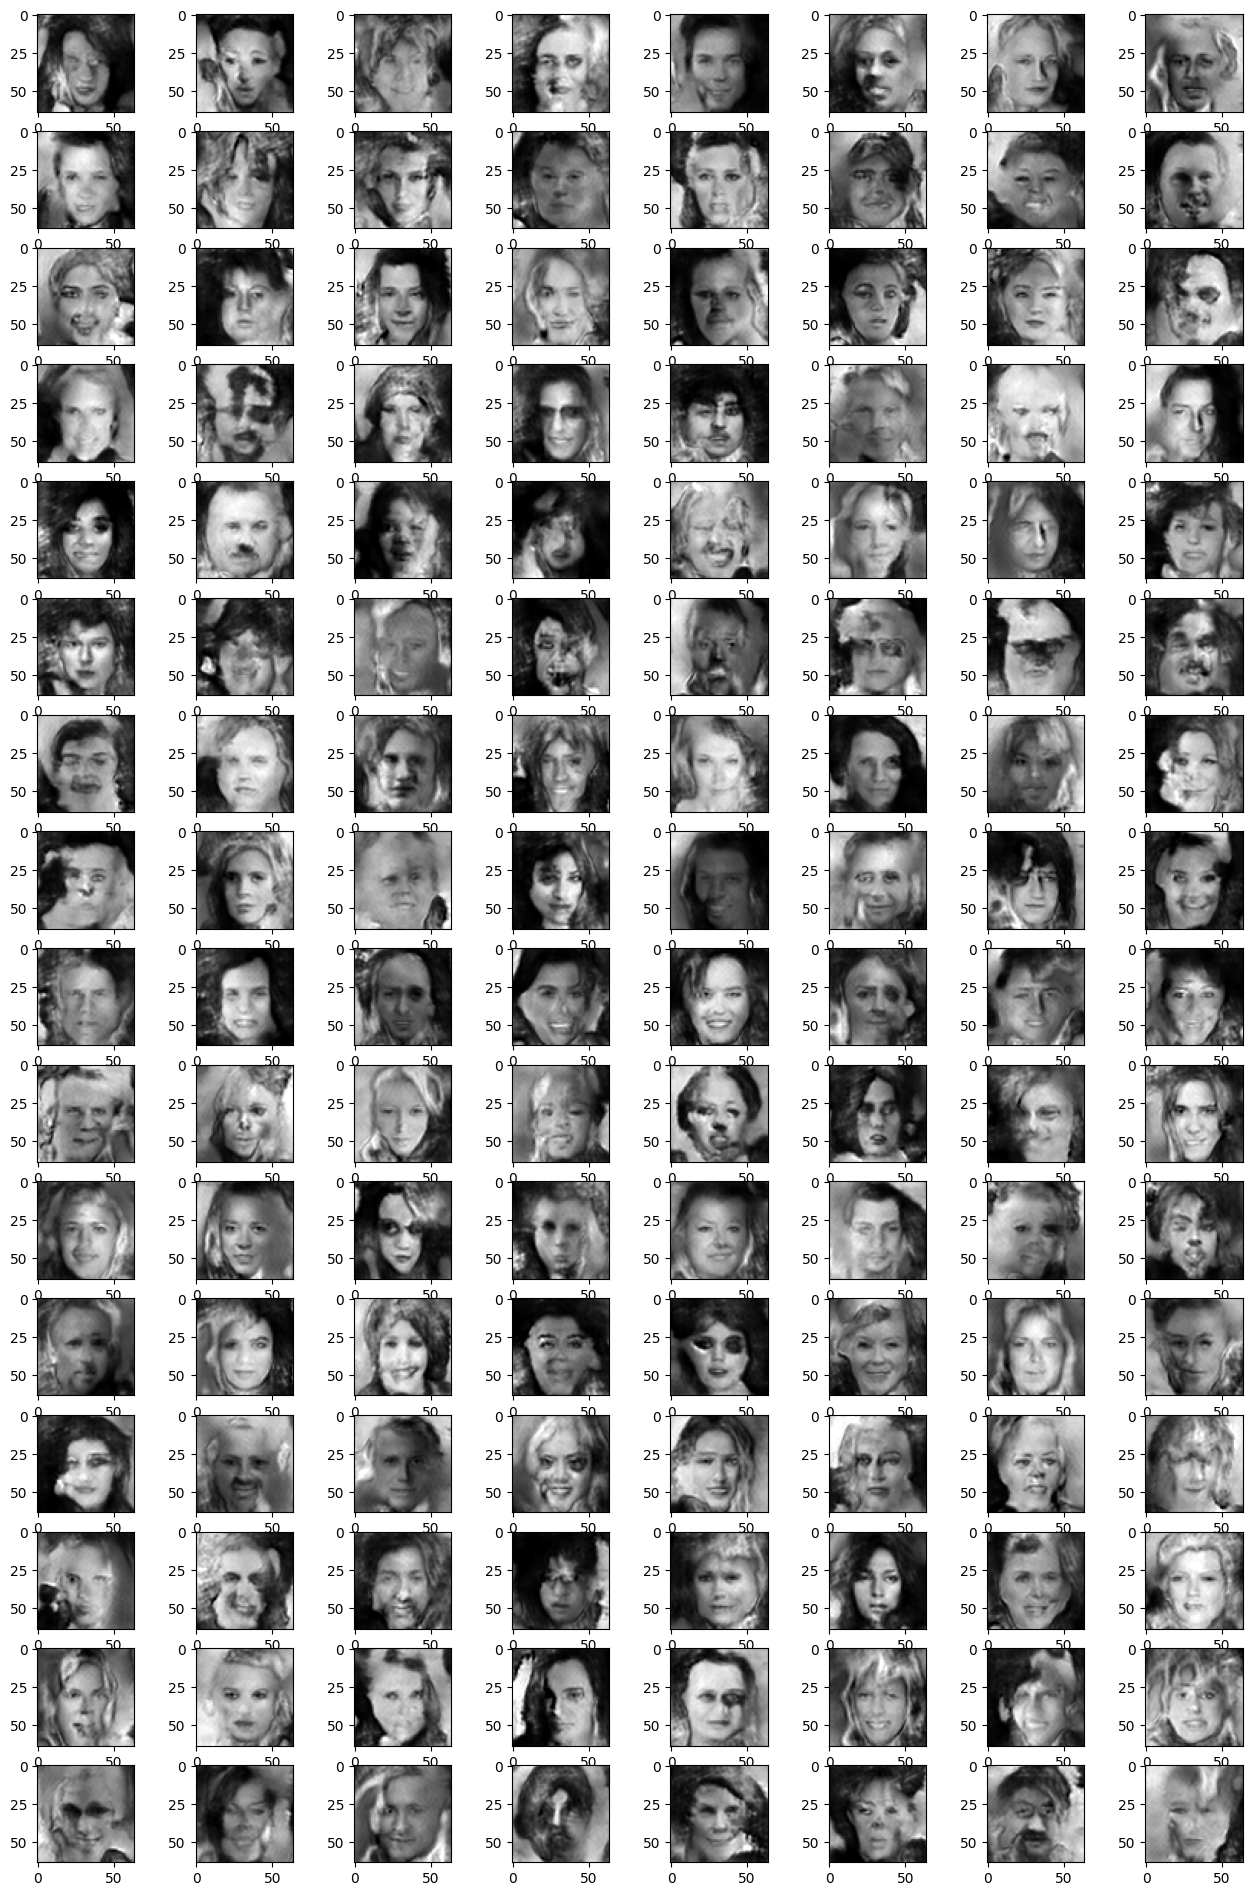

In [24]:
#!L
plt.figure(figsize=[16, 24])
sample_images(16, 8)

Ура, много кривых людей. Но в целом это не так плохо

In [26]:
from google.colab import files
torch.save(generator.state_dict(), 'generator')
files.download('generator')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from google.colab import files
torch.save(discriminator.state_dict(), 'discriminator')
files.download('discriminator')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>